In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import matplotlib.pyplot as plt
from training.util import plot_losses, sgd, adam, nll_loss
from training.regresssion import RegressionResults, plot_calibration, plot_table
from training import toy
from experiments.base.toy_regression import gap_datasets, plot_grid, store_results, NOISE

/home/flo/anaconda3/envs/bdl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

In [20]:
from training.pp import MAP
from training.swag import SwagModel
from training.ensemble import Ensemble
from training.bbb import GaussianPrior, BBBModel
#from training.gp import GaussianProcess
from training.rms import RMSModule
from training.sgld import sgld, psgld, SGLDModule
from training.vogn import VOGNModule

def train_models(dataset, batch_size):
    torch.manual_seed(42)
    trainloader = torch.utils.data.DataLoader(dataset.trainset, batch_size=batch_size)


    # torch.manual_seed(42)
    # gp = GaussianProcess(dataset.normalized_xs, dataset.normalized_ys, NOISE / dataset.y_std**2)
    # gp.train_model(100, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    pp = MAP(layers)
    pp.train_model(80, nll_loss, adam(lr=0.001), trainloader, batch_size, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    swag_config = {
        "start_epoch": 50,
        "mean_samples": 30,
        "deviation_samples": 30
    }
    swag = SwagModel(layers, swag_config)
    swag.train_model(80, nll_loss, adam(lr=0.001), trainloader, batch_size, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    diag_swag_config = {
        "start_epoch": 50,
        "mean_samples": 30,
        "deviation_samples": 30,
        "use_low_rank_cov": False
    }
    diag_swag = SwagModel(layers, diag_swag_config)
    diag_swag.train_model(80, nll_loss, adam(lr=0.001), trainloader, batch_size, device, report_every_epochs=-1)

    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    multi_swag_config = {
        "start_epoch": 50,
        "mean_samples": 30,
        "deviation_samples": 30
    }
    multi_swag = Ensemble([SwagModel(layers, multi_swag_config) for _ in range(10)])
    multi_swag.train_model(80, nll_loss, adam(lr=0.001), trainloader, 20, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    ensemble = Ensemble([MAP(layers) for _ in range(10)])
    ensemble.train_model(80, nll_loss, adam(0.001), trainloader, batch_size, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    rms = Ensemble([RMSModule(layers, torch.tensor(1.0), dataset.normalized_noise, 5.0) for _ in range(10)])
    rms.train_model(80, nll_loss, adam(0.001), trainloader, batch_size, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    mc_dropout = MAP(layers)
    mc_dropout.train_model(100, nll_loss, adam(0.001), trainloader, batch_size, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    multi_mc_dropout = Ensemble([MAP(layers) for _ in range(10)])
    multi_mc_dropout.train_model(100, nll_loss, adam(0.001), trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    bbb_prior = GaussianPrior(0, 1)
    layers = [
        ("v_fc", (1, 32, bbb_prior, {"rho_init": -3})),
        ("relu", ()),
        ("v_fc", (32, 32, bbb_prior, {"rho_init": -3})),
        ("relu", ()),
        ("v_fc", (32, 1, bbb_prior, {"rho_init": -3})),
        ("gauss", (dataset.normalized_noise, False))
    ]
    bbb = BBBModel(layers)
    bbb.train_model(120, nll_loss, adam(lr=0.001), trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5,  mc_samples=2)

    torch.manual_seed(42)
    bbb_prior = GaussianPrior(0, 1)
    layers = [
        ("v_fc", (1, 32, bbb_prior, {"rho_init": -3})),
        ("relu", ()),
        ("v_fc", (32, 32, bbb_prior, {"rho_init": -3})),
        ("relu", ()),
        ("v_fc", (32, 1, bbb_prior, {"rho_init": -3})),
        ("gauss", (dataset.normalized_noise, False))
    ]
    multi_bbb = Ensemble([BBBModel(layers) for _ in range(10)])
    multi_bbb.train_model(120, nll_loss, adam(lr=0.001), trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5,  mc_samples=2)

    torch.manual_seed(42)
    layers = [
        ("vlr_fc", (1, 32, 2, 1, {"rho_init": -3})),
        ("relu", ()),
        ("vlr_fc", (32, 32, 2, 1, {"rho_init": -3})),
        ("relu", ()),
        ("vlr_fc", (32, 1, 2, 1, {"rho_init": -3})),
        ("gauss", (dataset.normalized_noise, False))
    ]
    bbb_lr2 = BBBModel(layers)
    bbb_lr2.train_model(120, nll_loss, adam(lr=0.001), trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5, mc_samples=2)

    torch.manual_seed(42)
    layers = [
        ("vlr_fc", (1, 32, 10, 1, {"rho_init": -3})),
        ("relu", ()),
        ("vlr_fc", (32, 32, 10, 1, {"rho_init": -3})),
        ("relu", ()),
        ("vlr_fc", (32, 1, 10, 1, {"rho_init": -3})),
        ("gauss", (dataset.normalized_noise, False))
    ]
    bbb_lr10 = BBBModel(layers)
    bbb_lr10.train_model(120, nll_loss, adam(lr=0.001), trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5, mc_samples=2)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    vogn = VOGNModule(layers)
    vogn.train_model(100, nll_loss, {"lr": 1e-2, "prior_prec": 10, "damping": 1e-6, "betas": (0.9, 0.999)}, trainloader, 20, device, report_every_epochs=-1, mc_samples=10)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    multi_vogn = Ensemble([VOGNModule(layers) for _ in range(10)])
    multi_vogn.train_model(100, nll_loss, {"lr": 1e-2, "prior_prec": 10, "damping": 1e-6, "betas": (0.9, 0.999)}, trainloader, 20, device, report_every_epochs=-1, mc_samples=10)
    
    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    ivon = iVONModuleFunctorch(layers)
    ivon.train_model(100, nll_loss, {"lr": 1e-2, "prior_prec": 10, "damping": 1e-6, "betas": (0.9, 0.999)}, trainloader, 20, device, report_every_epochs=-1, mc_samples=10)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1)),
        ("gauss", (dataset.normalized_noise, False))
    ]
    multi_ivon = Ensemble([iVONModuleFunctorch(layers) for _ in range(10)])
    multi_ivon.train_model(100, nll_loss, {"lr": 1e-2, "prior_prec": 10, "damping": 1e-6, "betas": (0.9, 0.999)}, trainloader, 20, device, report_every_epochs=-1, mc_samples=10)

    return [pp, ensemble, swag, diag_swag, multi_swag, mc_dropout, multi_mc_dropout, bbb, multi_bbb, bbb_lr2, bbb_lr10, rms, vogn, multi_vogn, ivon, multi_ivon]

Running chain 0
Epoch 0: loss 15.149736404418945
SGLD: Burnin completed in epoch 100; now collecting posterior samples
Epoch 1000: loss 2.7710821628570557
SGLD: Collected 1000 posterior samples
Running chain 1
Epoch 0: loss 15.182908058166504
SGLD: Burnin completed in epoch 100; now collecting posterior samples
Epoch 1000: loss -0.00450834259390831
SGLD: Collected 2000 posterior samples
Running chain 2
Epoch 0: loss 14.991804122924805
SGLD: Burnin completed in epoch 100; now collecting posterior samples
Epoch 1000: loss -0.26967430114746094
SGLD: Collected 3000 posterior samples
Running chain 3
Epoch 0: loss 13.526081085205078
SGLD: Burnin completed in epoch 100; now collecting posterior samples
Epoch 1000: loss -0.45172441005706787
SGLD: Collected 4000 posterior samples
Running chain 4
Epoch 0: loss 14.991442680358887
SGLD: Burnin completed in epoch 100; now collecting posterior samples
Epoch 1000: loss -0.2921624481678009
SGLD: Collected 5000 posterior samples
Running chain 5
Epoch 0

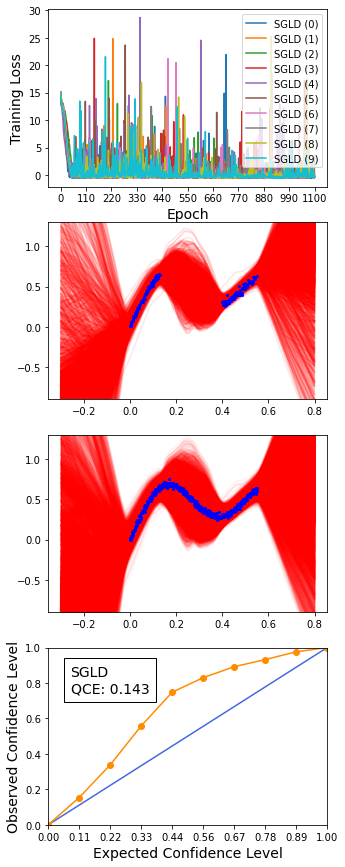

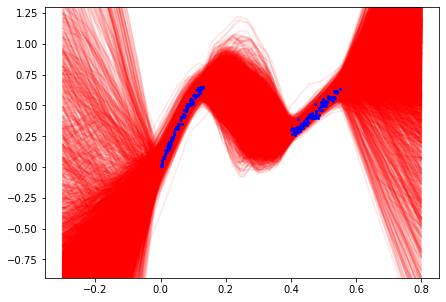

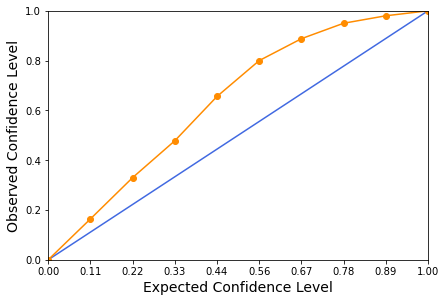

In [4]:
from training.pp import MAP
from training.sgld import sgld, psgld, SGLDModule
from training.util import nll_loss

torch.manual_seed(0)

dataset, trainloader, testset = gap_datasets(device)

layers = [
    ("fc", (1, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("fc", (32, 1)),
    ("gauss", (dataset.normalized_noise, False))
]
model = SGLDModule(layers, 100, 1, 10)
model.train_model(1100, nll_loss, sgld(lr=5e-5), trainloader, 20, device, report_every_epochs=1000)
plot_grid(dataset, testset, [("SGLD", model, 10000)], device, plot_ground_truth=False)
store_results(dataset, testset, [("sgld", model, 10000)], device, plot_ground_truth=False)

Epoch 0: loss 31.060413360595703
Epoch 20: loss 0.42955413460731506
Epoch 40: loss -0.12901581823825836
Epoch 60: loss -0.18659798800945282
Epoch 80: loss -0.5814775228500366
Final loss -0.6892471313476562
Test LML (MAP): 0.8984813690185547


(<Figure size 360x1080 with 4 Axes>,
 [<training.regresssion.RegressionResults at 0x7fa1de2d3eb0>])

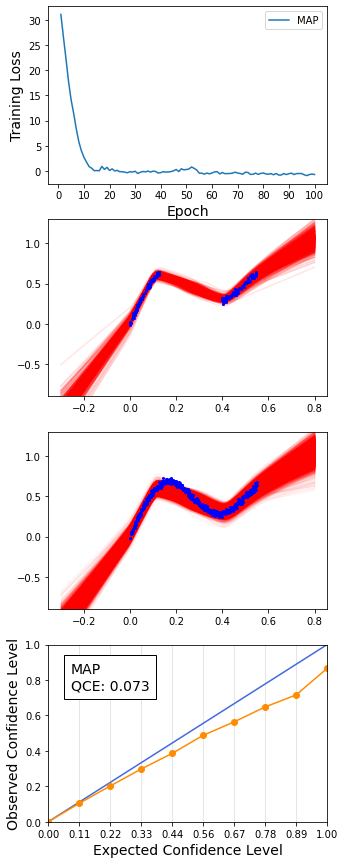

In [19]:
from training.vogn import VOGNModule, iVONModule, iVONModuleFunctorch

torch.manual_seed(42)

dataset, trainloader, testset = gap_datasets(device)

torch.manual_seed(42)
layers = [
    ("fc", (1, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("fc", (32, 1)),
    ("gauss", (dataset.normalized_noise, False))
]
model = VOGNModule(layers)
model.train_model(100, nll_loss, {"lr": 1e-2, "prior_prec": 10, "damping": 1e-6, "betas": (0.9, 0.999)}, trainloader, 20, device, report_every_epochs=20, mc_samples=10)

plot_grid(dataset, testset, [("MAP", model, 1000)], device, plot_ground_truth=False)

Epoch 0: loss 2.1668601036071777
Epoch 20: loss 2.04785418510437
Epoch 40: loss 1.8729891777038574
Epoch 60: loss 1.303503155708313
Epoch 80: loss 0.8016999959945679
Epoch 100: loss 0.7867379188537598
Epoch 120: loss 0.7656209468841553
Epoch 140: loss 0.7603166699409485
Epoch 160: loss 0.7349472045898438
Epoch 180: loss 0.7180790901184082
Final loss 0.7432856559753418
Test LML (BBB): -0.18595720827579498


(<Figure size 360x1080 with 4 Axes>,
 [<training.regresssion.RegressionResults at 0x7fa8b399fca0>])

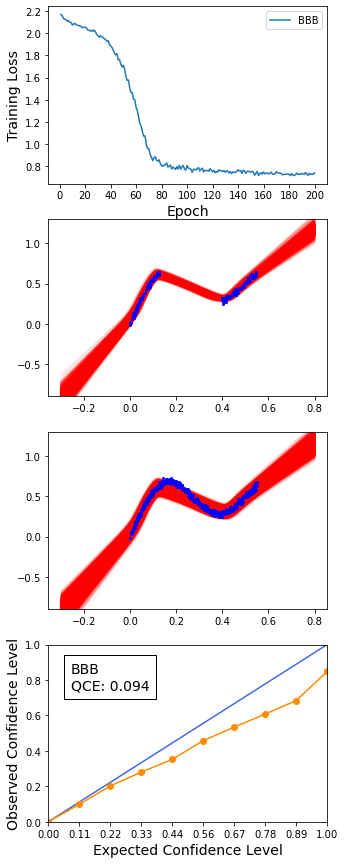

In [5]:
torch.manual_seed(42)

dataset, trainloader, testset = gap_datasets(device)

bbb_prior = GaussianPrior(0, 1)
layers = [
    ("v_fc", (1, 32, bbb_prior, {"rho_init": -3})),
    ("relu", ()),
    ("v_fc", (32, 32, bbb_prior, {"rho_init": -3})),
    ("relu", ()),
    ("v_fc", (32, 1, bbb_prior, {"rho_init": -3})),
    ("gauss", (dataset.normalized_noise, False))
]
bbb = BBBModel(layers)
bbb.train_model(200, nll_loss, sgd(lr=0.001), trainloader, 20, device, report_every_epochs=20, kl_rescaling=1,  mc_samples=2)

plot_grid(dataset, testset, [("BBB", bbb, 1000)], device, plot_ground_truth=False)


torch.Size([1153])
tensor(0.0367, grad_fn=<MinBackward1>)
tensor(0.0488, grad_fn=<MeanBackward0>)
tensor(0.0491, grad_fn=<MaxBackward1>)


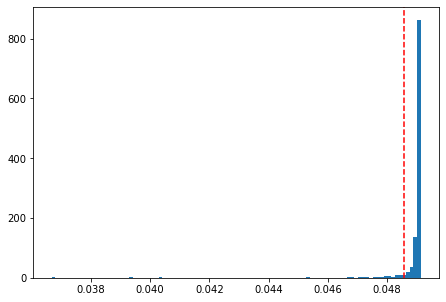

In [20]:
result = torch.tensor([])
for module in bbb.model:
    if (hasattr(module, "sigmas")):
        result = torch.cat([result, module.sigmas()])

plt.hist(result.detach().numpy(), bins=100)[1]
plt.axvline(torch.nn.functional.softplus(torch.tensor(-3.0)), color="red", linestyle="--")
plt.tight_layout(pad=0)
#plt.savefig("results/vi/sigma_hist_1.pdf")
print(result.shape)
print(result.min())
print(result.mean())
print(result.max())

In [11]:
results = [[] for _ in range(11)]

for seed in range(10):
    print(f"===== {seed}")
    dataset, trainloader, testset = gap_datasets(device)
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

    models = []
    eval_configs = []
    for K in range(1, 22, 2):
        print(f"== {K}")
        torch.manual_seed(seed)

        layers = [
            ("vlr_fc", (1, 32, K, 1, {"rho_init": -3, "offdiag_init": 0.005})),
            ("relu", ()),
            ("vlr_fc", (32, 32, K, 1, {"rho_init": -3, "offdiag_init": 0.005})),
            ("relu", ()),
            ("vlr_fc", (32, 1, K, 1, {"rho_init": -3, "offdiag_init": 0.005}))
        ]
        bbb_lrK = wrap(BBBModel(layers), dataset)
        bbb_lrK.train_model(250, adam(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=0, kl_rescaling=0.5, mc_samples=2)
        models.append(bbb_lrK)
        eval_configs.append((f"LRVI-{K}", bbb_lrK, 1000))

    for i, (name, model, samples) in enumerate(eval_configs):
        results[i].append(RegressionResults(testloader, name, model.infer, samples, device, target_mean=dataset.y_mean, target_std = dataset.y_std))

===== 0
== 1
Final loss -0.037027835845947266
== 3
Final loss -0.03499143198132515
== 5
Final loss -0.03178078681230545
== 7
Final loss -0.03696742653846741
== 9
Final loss -0.03603125736117363
== 11
Final loss -0.035633817315101624
== 13
Final loss -0.03655293583869934
== 15
Final loss -0.03675404191017151
== 17
Final loss -0.03648023307323456
== 19
Final loss -0.03233423829078674
== 21
Final loss -0.036170843988657
===== 1
== 1
Final loss -0.03646283969283104
== 3
Final loss -0.039832357317209244
== 5
Final loss -0.03935950621962547
== 7
Final loss -0.03760188817977905
== 9
Final loss -0.03802187368273735
== 11
Final loss -0.03920073062181473
== 13
Final loss -0.03793386369943619
== 15
Final loss -0.03797808289527893
== 17
Final loss -0.038597311824560165
== 19
Final loss -0.03869035840034485
== 21
Final loss -0.0390123575925827
===== 2
== 1
Final loss -0.03754476457834244
== 3
Final loss -0.03601428121328354
== 5
Final loss -0.038082484155893326
== 7
Final loss -0.03981870412826538


| Gap Toy Regression   | Avg LML      | Mean MSE      | MSE of Means   | QCE         |
|----------------------+--------------+---------------+----------------+-------------|
| LRVI-1               | 0.26 ± 0.18  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-3               | 0.04 ± 0.19  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-5               | 0.02 ± 0.14  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-7               | 0.14 ± 0.24  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-9               | 0.10 ± 0.19  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-11              | 0.06 ± 0.16  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-13              | 0.03 ± 0.17  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-15              | 0.10 ± 0.16  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-17              | 0.12 ± 0.15  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-19              | -0.05 ± 0.14 | 0.0

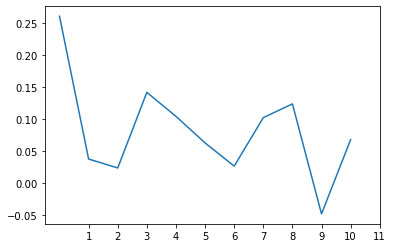

In [12]:
plot_table("Gap Toy Regression", results, "results/toy/regression_gap_lr.txt")

Test LML (BBB LR-1): 0.8295542001724243
Test LML (BBB LR-2): 0.6116978526115417
Test LML (BBB LR-3): 0.8192546963691711
Test LML (BBB LR-4): 0.8078017830848694
Test LML (BBB LR-5): 0.6128537058830261
Test LML (BBB LR-6): 0.8156030774116516
Test LML (BBB LR-7): 1.145634651184082
Test LML (BBB LR-8): 0.805411696434021
Test LML (BBB LR-9): 0.9608200788497925
Test LML (BBB LR-10): 0.9975020885467529
Test LML (BBB LR-11): 0.8234630823135376
Test LML (BBB LR-12): 1.1964620351791382
Test LML (BBB LR-13): 0.8556326031684875
Test LML (BBB LR-14): 0.8968547582626343
Test LML (BBB LR-15): 0.6951597332954407
Test LML (BBB LR-16): 0.6906633973121643
Test LML (BBB LR-17): 0.8977761268615723
Test LML (BBB LR-18): 0.8443577885627747
Test LML (BBB LR-19): 0.7314607501029968
Test LML (BBB LR-20): 0.987156867980957


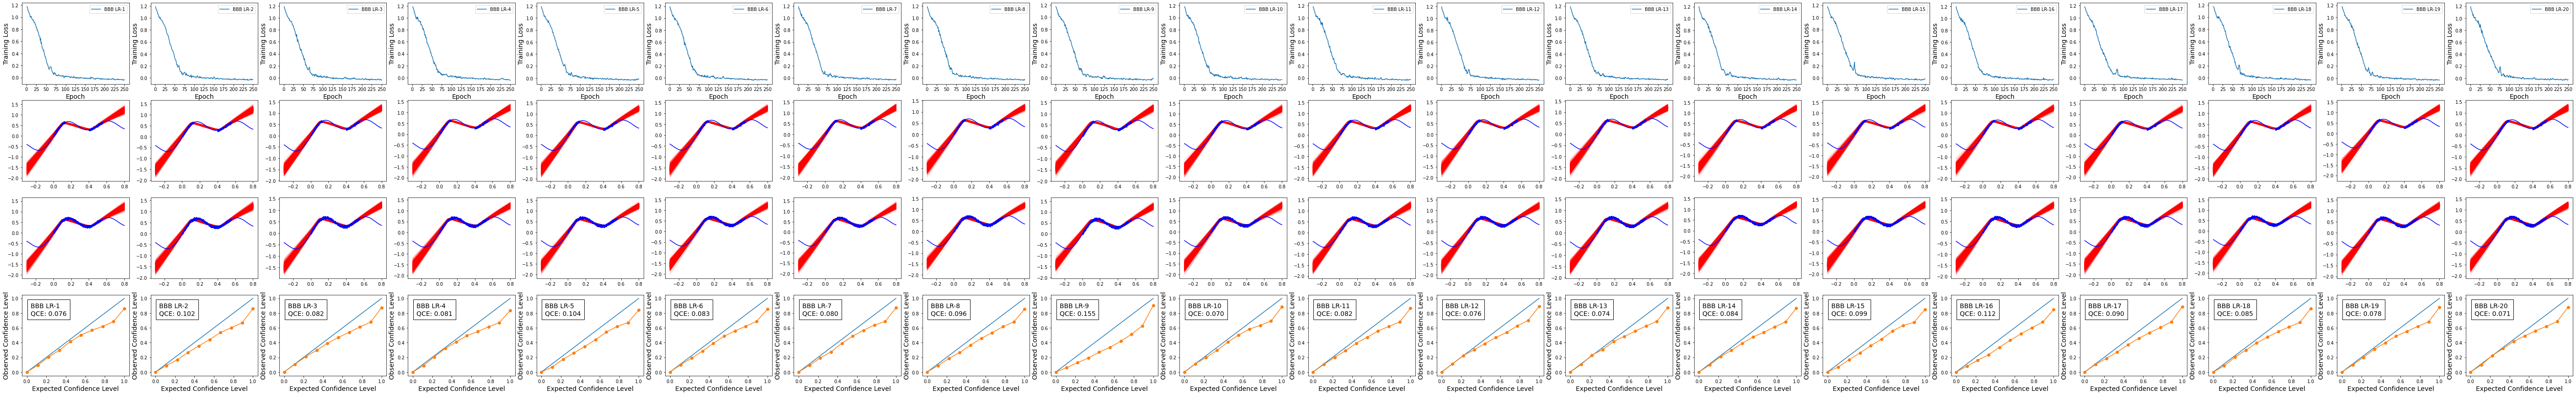

In [78]:
plot_grid(dataset, testset, -0.3, 0.8, eval_configs, device)[0].savefig("results/toy/regression_gap_lr.pdf")

In [ ]:
torch.manual_seed(42)
dataset = toy.TrigonometricToyDataset([(0, 0.5, 200)], noise)
dataset.plot_dataset(-0.2, 0.7, plt.subplot())

models = train_models(dataset, 20)

fig, results = plot_grid(dataset, dataset.generate_testset(0.0, 0.5, 200, noise), -0.1, 0.6, [
    ("Gaussian Process", models[0], 1000),
    ("MAP", models[1], 1000),
    ("Ensemble-5", models[2], 1000),
    ("SWAG", models[3], 1000),
    ("SWAG-Diagonal", models[4], 1000),
    ("MC Dropout", models[5], 1000),
    ("Bayes By Backprop", models[6], 1000),
    ("Bayes By Backprop (LL)", models[7], 1000)
], device)

#fig.savefig("results/toy/regression_simple.png")

#plot_table("Simple Toy Regression", [[result] for result in results], "results/toy/regression_simple.txt")

Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9
Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9
Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9
Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
T

/home/flo/VariationalBayesianDL/experiments/base/toy_regression.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1)


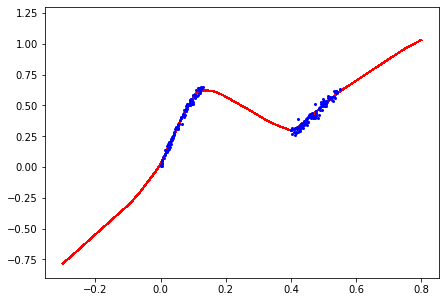

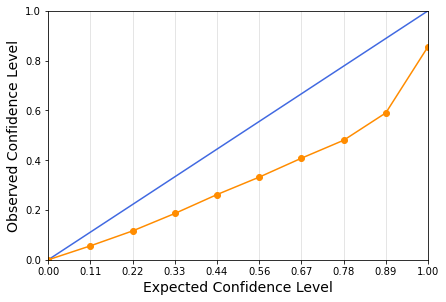

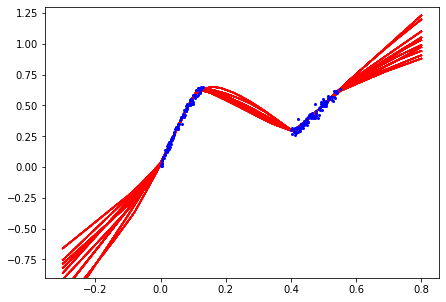

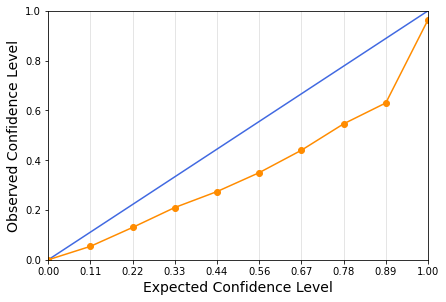

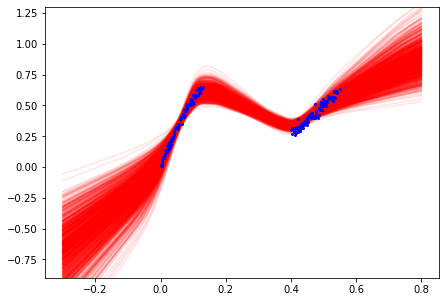

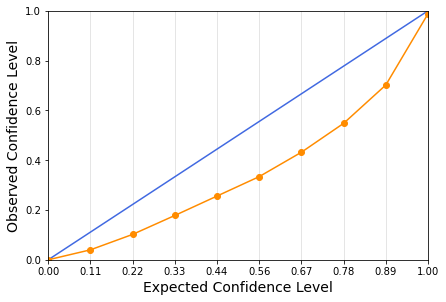

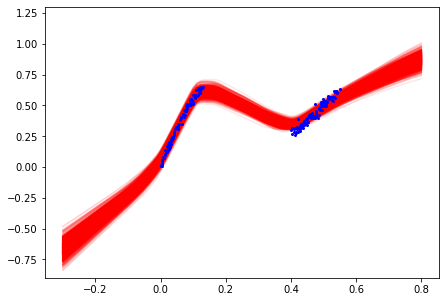

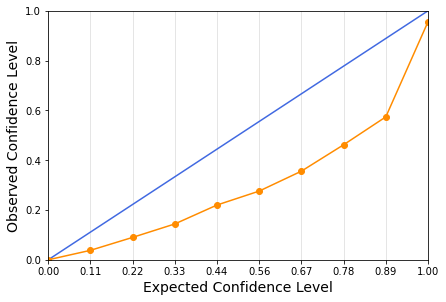

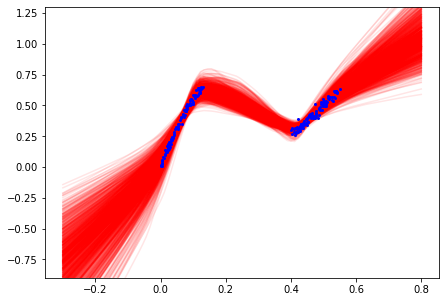

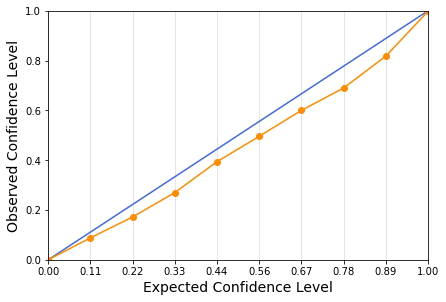

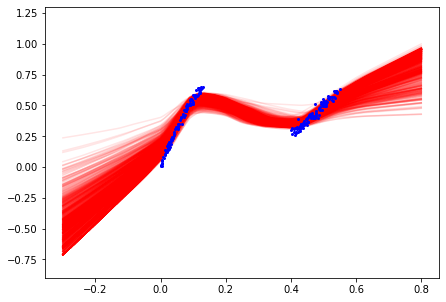

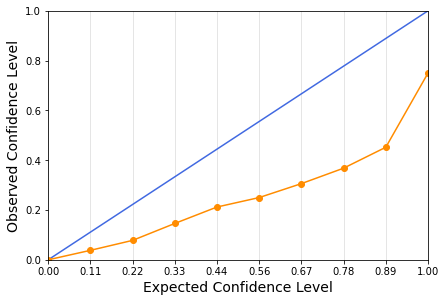

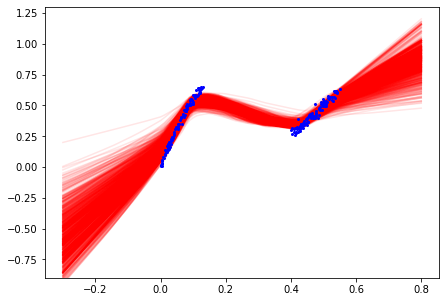

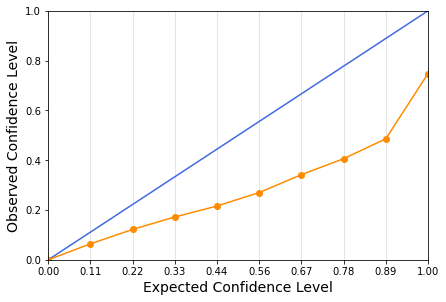

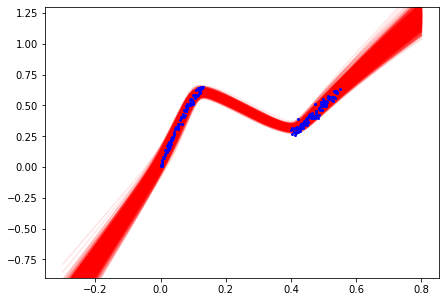

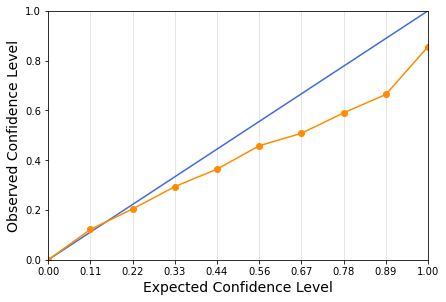

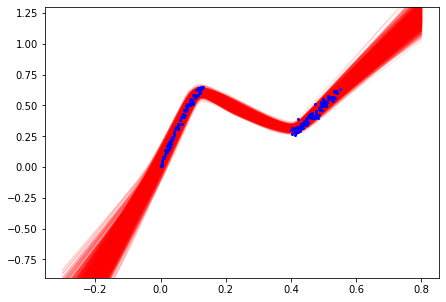

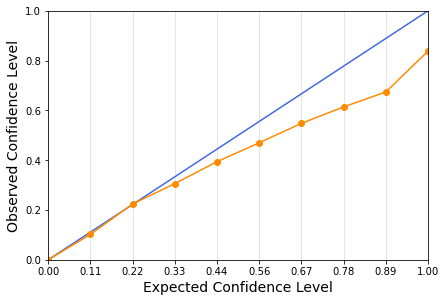

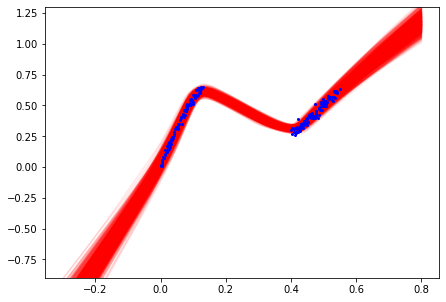

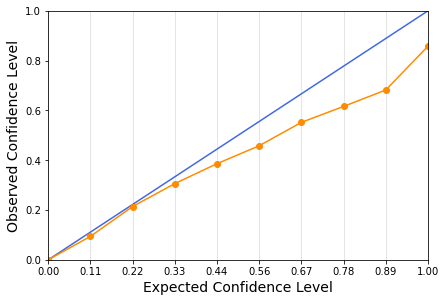

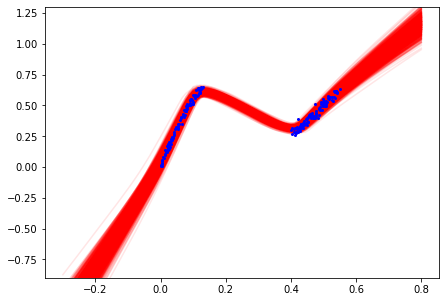

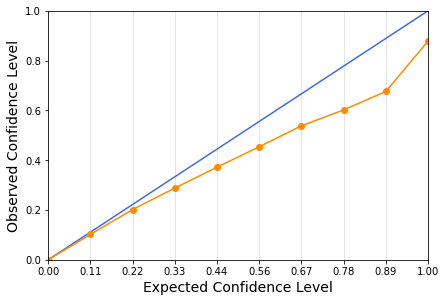

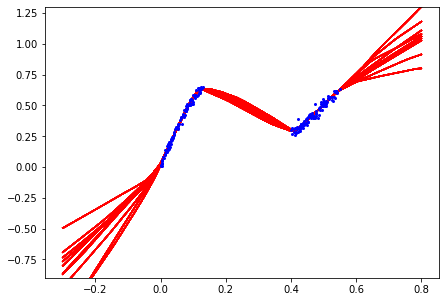

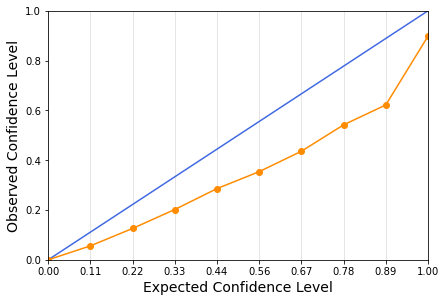

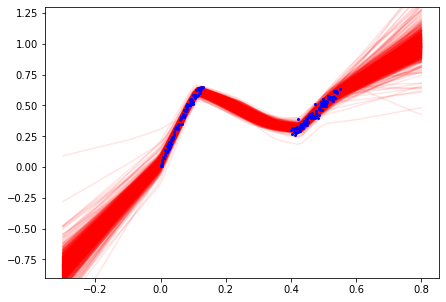

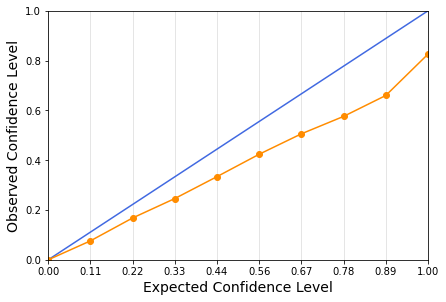

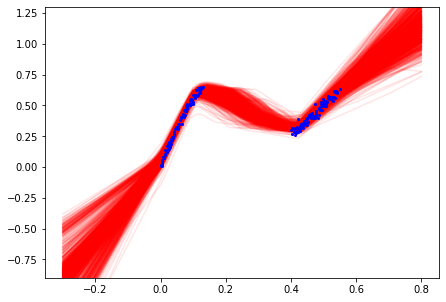

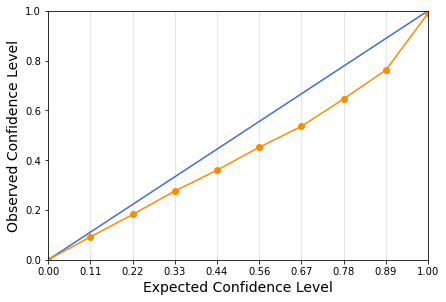

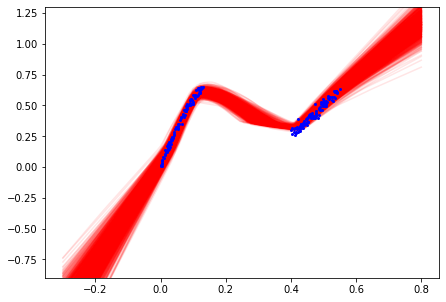

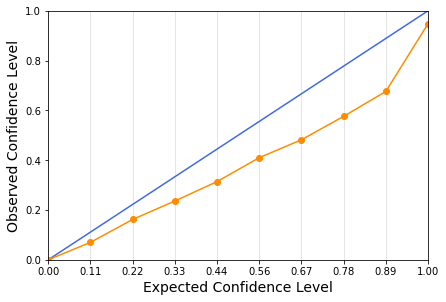

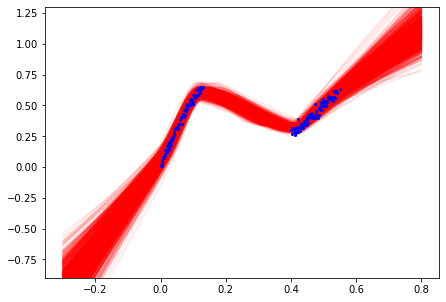

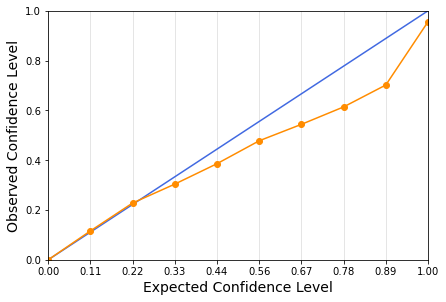

In [21]:
def make_config(models):
    return [
        ("map", models[0], 1000),
        ("ensemble", models[1], 1000),
        ("swag", models[2], 1000),
        ("swag_diag", models[3], 1000),
        ("multiswag", models[4], 1000),
        ("mcd", models[5], 1000),
        ("multimcd", models[6], 1000),
        ("mfvi_0_5", models[7], 1000),
        ("multimfvi_0_5", models[8], 1000),
        ("lrvi_2", models[9], 1000),
        ("lrvi_10", models[10], 1000),
        ("rms", models[11], 1000),
        ("vogn", models[12], 1000),
        ("multi_vogn", models[13], 1000),
        ("ivon", models[14], 1000),
        ("multi_ivon", models[15], 1000),
    ]

results = [[] for _ in range(13)]
for seed in range(1):
    torch.manual_seed(seed)
    dataset, dataloader, testset = gap_datasets(device)
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

    models = train_models(dataset, 20)

    #config = make_config(models)
    #for i, (name, model, samples) in enumerate(config):
    #    results[i].append(RegressionResults(testloader, name, model.infer, samples, device, target_mean=dataset.y_mean, target_std=dataset.y_std))
#plot_table("Gap Toy Regression", results, "results/toy/regression_gap.txt")

#fig, _ = plot_grid(dataset, testset, eval_configs, device, plot_ground_truth=False)
#fig.savefig("results/toy/regression_gap.png")

store_results(dataset, testset, make_config(models), device)



| Gap Toy Regression   | Avg LML     | Mean MSE      | MSE of Means   | QCE         |
|----------------------+-------------+---------------+----------------+-------------|
| map                  | 0.51 ± 0.09 | 0.002 ± 0.000 | 0.002 ± 0.000  | 0.16 ± 0.00 |
| ensemble             | 0.88 ± 0.06 | 0.002 ± 0.000 | 0.002 ± 0.000  | 0.12 ± 0.01 |
| swag                 | 1.51 ± 0.03 | 0.004 ± 0.000 | 0.003 ± 0.000  | 0.08 ± 0.01 |
| swag_diag            | 1.22 ± 0.05 | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.11 ± 0.01 |
| multiswag            | 1.42 ± 0.05 | 0.004 ± 0.000 | 0.002 ± 0.000  | 0.03 ± 0.00 |
| mcd                  | 0.41 ± 0.14 | 0.006 ± 0.000 | 0.004 ± 0.000  | 0.10 ± 0.00 |
| multimcd             | 1.03 ± 0.08 | 0.006 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| mfvi_0_5             | 0.49 ± 0.11 | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.09 ± 0.01 |
| multimfvi_0_5        | 0.88 ± 0.14 | 0.004 ± 0.000 | 0.003 ± 0.000  | 0.07 ± 0.00 |
| lrvi_2               | 0.82 ± 0.10 | 0.003 ± 0.000 |

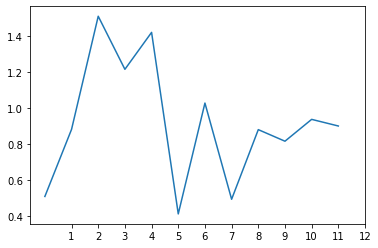

In [30]:
plot_table("Gap Toy Regression", results, "results/toy/regression_gap.txt")